<a href="https://colab.research.google.com/github/jiukeem/deeplearning_from_scratch/blob/master/convolution_NN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np


In [64]:
class ConvolutionNetwork:
  def __init__(self, learning_rate=0.1, n_kernels=10, units=10, batch_size=32):
    self.n_kernels = n_kernels
    self.kernel_size = 3
    self.optimizer = None
    self.conv_w = None
    self.conv_b = None
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate

  def forpass(self, x):
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b # 합성곱
    r_out = tf.nn.relu(c_out) # 활성화단계(렐루)
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID') # 풀링 단계. 결과물은 (sample, 14, 14, 10)
    f_out = tf.reshape(p_out, [x.shape[0], -1]) # 넘파이 어레이로 바꾸지 않더라도 tf.reshape 이 있음
    z1 = tf.matmul(f_out, self.w1) + self.b1 # 계속 텐서 객체를 다루기 때문에 변환 후 np.dot을 사용하지 않고 tf.matmul 사용
    a1 = tf.nn.relu(z1) # 렐루는 위에서랑 똑같이 쓰는 걸 보니 디멘션은 상관 없는 듯
    z2 = tf.matmul(a1, self.w2) + self.b2
    return z2    
    
  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    # xavier 풀네임이 xavier glorot 임ㅋㅋㅋ 좋겠다 이름붙인거 많아서...
    # 즉 이 함수는 xavier initialization을 실행해줌
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels))) # g 안에는 튜플 형식으로 넣어줘야하기 때문에 괄호가 한번 더 싸인 것 유의
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
    # 책에서는 np.zeros(self.n_kernel) 이렇게 했는데 이래도 되나? 계속 요 부분이 헷갈린다.
    # zeros() takes at most 3 arguments (4 given) 라고 에러뜸 np.zeros(1, 1, 1, self.n_kernel)는 안되나보다
    n_features = self.n_kernels * 14 * 14  # 풀링레이어를 펼칠 때
    self.w1 = tf.Variable(g((n_features, self.units)))
    self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
    self.w2 = tf.Variable(g((self.units, n_classes)))
    self.b2 = tf.Variable(np.zeros(n_classes), dtype=float) 
    # tf.Variable 함수로 선언할 때 입력값에 따라 자료'형이 결정된다. tf는 32비트 실수로 나오고 np는 64비트 실수로 나오기 때문에 통일해주기 위하여 
    # np.zero들을 dtype=float 으로 지정했다.  

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape, y.shape[1])
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    for i in range(epochs):
      print('에포크', i+1, end='')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        self.training(x_batch, y_batch)
        batch_losses.append(self.get_loss(x_batch, y_batch))
      self.losses.append(np.mean(batch_losses))
      self.val_losses.append(self.get_loss(x_val, y_val))
      print()

  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size
    index = np.random.permutation(np.arange(len(x)))
    x = x[index]
    y = y[index]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start: end], y[start: end]

  def training(self, x, y):
   m = len(x)
   with tf.GradientTape() as tape: 
     # with 로 감싼 부분의 연산을 기록함. 즉 내가 원하는 gradient의 forward_prop이 여기에 적혀야 함
     # 그리고 tf.Variable 로 지정된 객체를 추적함 즉 y를 x로 미분하고 싶다면 with 안에 x와 y의 관계식이 적혀야하고 x는 tf.Variable로 지정해줘야함
     z = self.forpass(x)
     loss = tf.nn.softmax_cross_entropy_with_logits(y, z) 
     # 각 샘플에 대해 로스를 계산하므로 코스트를 원하면 합쳐서 평균 내줘야함
     # softmax를 진행하고 나서 A와 Y로 로스를 계산하는게 아니라 소프트맥스와 크로스 엔트로피 두 개가 합쳐져 있다. 
     # 소프트맥스는 Z 유닛간의 비율이기 때문에 Z값이 전체적으로 어떻게 변화하든지 그레디언트 값에는 영향을 주지 않기 때문
     loss = tf.reduce_mean(loss)

   weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2] # 이 웨이트들은 미분계산의 객체로 들어가기 때문에 tf.Variable() 함수로 initialization 해줘야 함
   grads = tape.gradient(loss, weights_list) # 각 가중치의 그레디언트들 리스트로 나오는지 텐서로 나오는지 모르겠음
   self.optimizer.apply_gradients(zip(grads, weights_list)) # 그레디언트와 가중치를 튜플로 묶은 리스트를 입력값으로 받음

  def get_loss(self, x, y):
    z = self.forpass(x) # 텐서플로로 진행하기 때문에 소프트맥스 함수 만들어서 A2 계산해줄 필요 없다.
    loss = tf.nn.softmax_cross_entropy_with_logits(y, z) 
    cost = tf.reduce_mean(loss)
    return cost.numpy() # 넘파이 어레이로 변환해서 return

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z.numpy(), axis=1) 
    # Z 중 가장 큰 값의 인덱스를 반환함. 
    # 정확한 값이 필요한게 아니라 가장 큰 값을 가지는 노드의 정보가 필요하므로 역시 A2 계산할 필요 없음

  def score(self, x, y):
    score = np.mean(self.predict(x) == np.argmax(y, axis=1))
    return score

In [53]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all,test_size=0.2, random_state=42)

In [55]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [56]:
x_train = x_train.reshape(-1, 28, 28, 1) # 예전처럼 펼칠 필요없음. 다만 컬러채널 디멘션을 추가해줬다
x_val = x_val.reshape(-1, 28, 28, 1)

In [57]:
x_train.shape

(48000, 28, 28, 1)

In [58]:
x_train = x_train / 255
x_val = x_val / 255

In [65]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 1
에포크 2
에포크 3
에포크 4
에포크 5
에포크 6
에포크 7
에포크 8
에포크 9
에포크 10
에포크 11
에포크 12
에포크 13
에포크 14
에포크 15
에포크 16
에포크 17
에포크 18
에포크 19
에포크 20


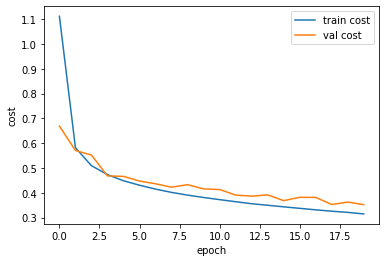

In [66]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train cost', 'val cost'])
plt.show()

In [67]:
cn.score(x_val, y_val_encoded)

0.87675